
[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


✅ Data Loaded Successfully
   magnitude  cdi  mmi  sig  nst   dmin   gap    depth  latitude  longitude  \
0        7.0    8    7  768  117  0.509  17.0   14.000   -9.7963    159.596   
1        6.9    4    4  735   99  2.229  34.0   25.000   -4.9559    100.738   
2        7.0    3    3  755  147  3.125  18.0  579.000  -20.0508   -178.346   
3        7.3    5    5  833  149  1.865  21.0   37.000  -19.2918   -172.129   
4        6.6    0    2  670  131  4.998  27.0  624.464  -25.5948    178.278   

   Year  Month  tsunami  
0  2022     11        1  
1  2022     11        0  
2  2022     11        1  
3  2022     11        1  
4  2022     11        1   

Number of rows: 782

Missing Values:
 magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64


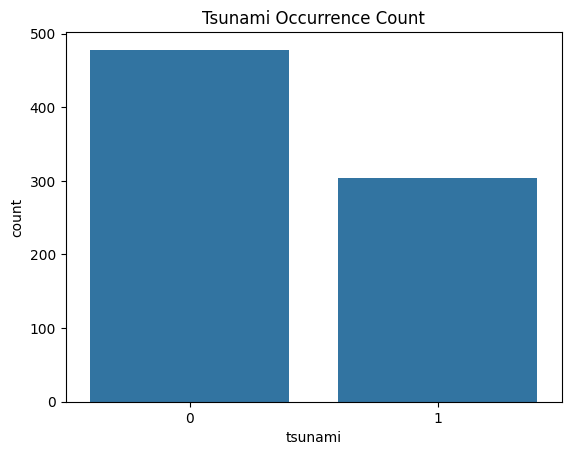

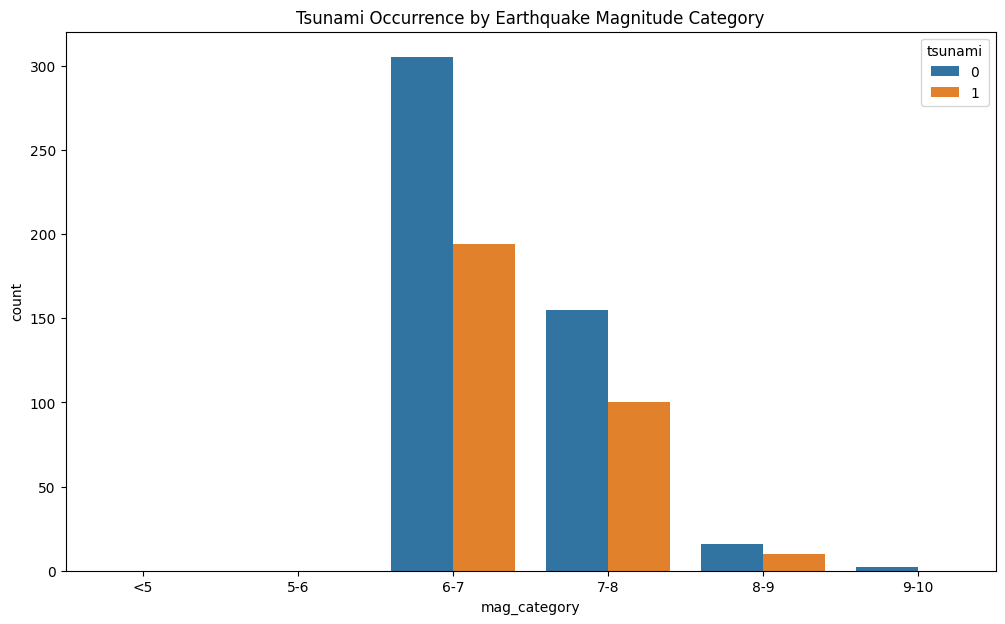

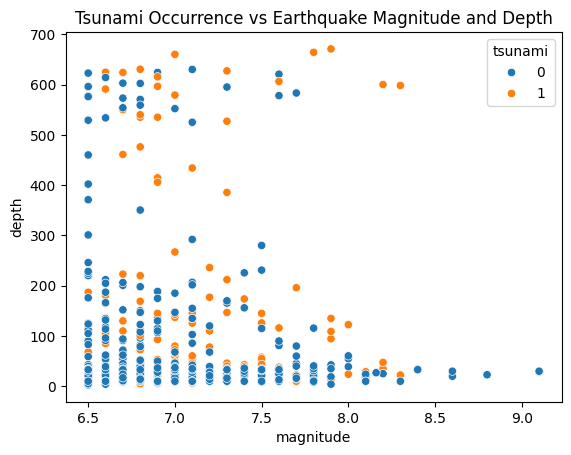

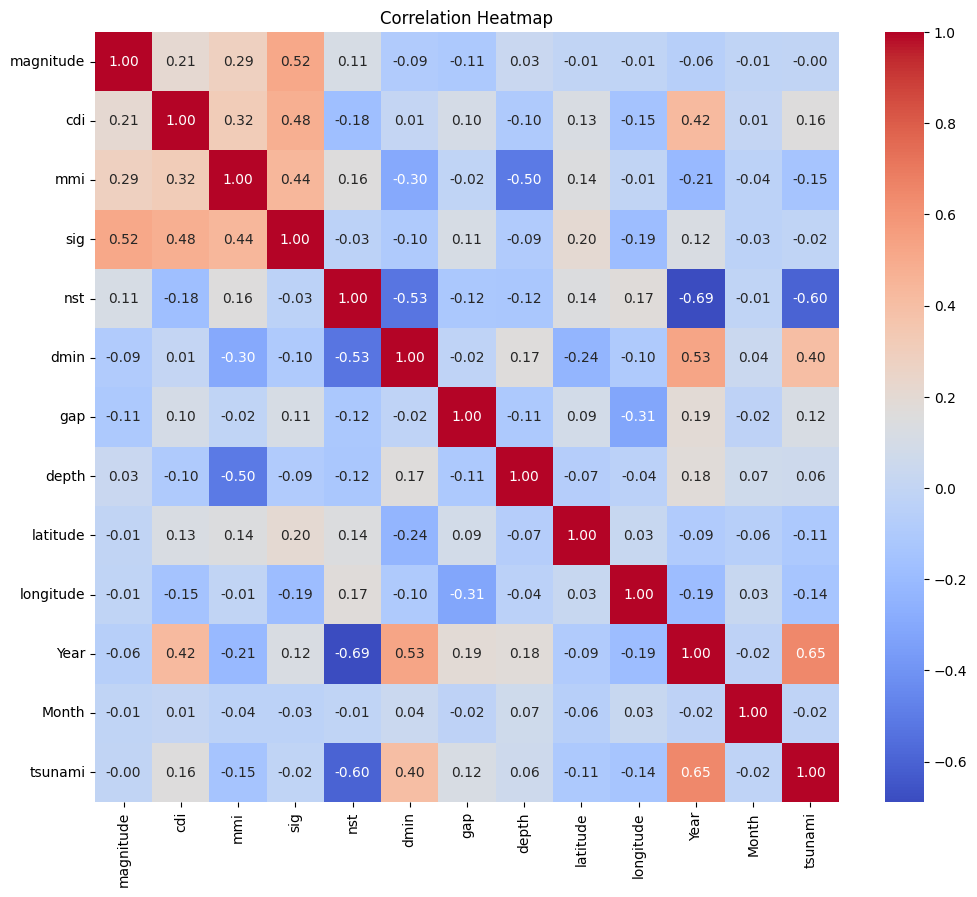

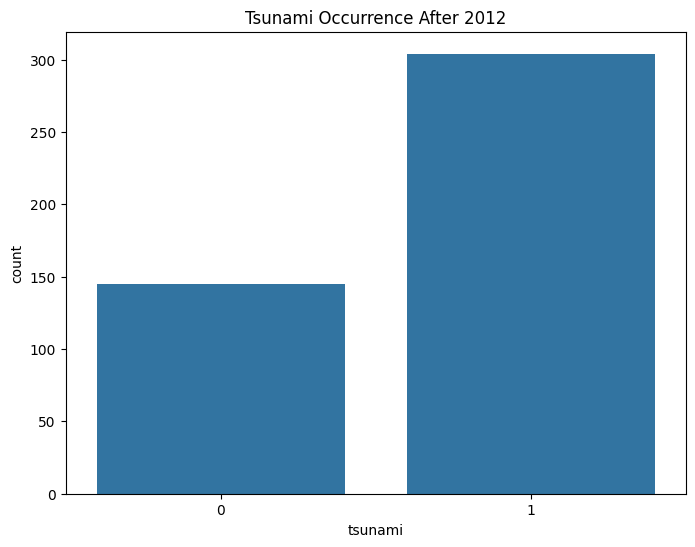

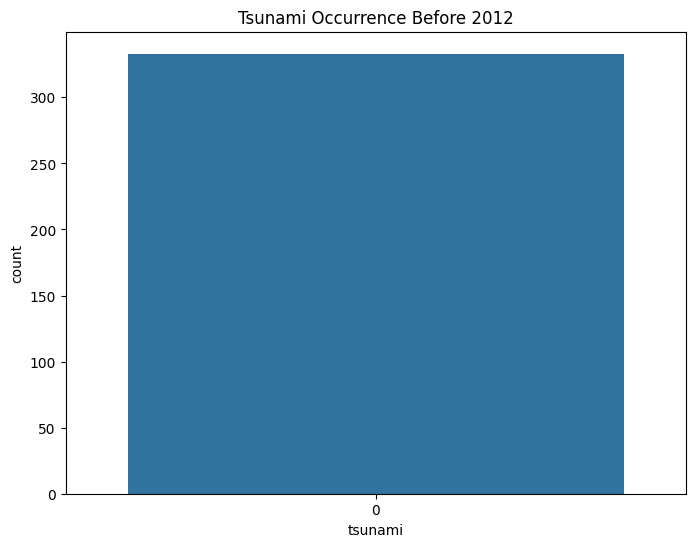

⚠️ Bias Found: Before 2012 → only 'tsunami=0' events.
✅ Fix: Use data from 2012 onwards only.

✅ Data Prepared: Train/Test Split Done

🚀 Training XGBoost model with GridSearchCV...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


C:\Users\ANAMITRA BAKSHI\AppData\Roaming\Python\Python313\site-packages\xgboost\training.py:199: UserWarning: [03:05:33] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



🌟 MODEL: XGBClassifier (Optimized)
Best Parameters: {'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 50, 'subsample': 0.6}

1️⃣ Accuracy: 0.8000
2️⃣ Balanced Accuracy: 0.7786
3️⃣ ROC AUC Score: 0.8229

4️⃣ Classification Report:
                 precision    recall  f1-score   support

Not Tsunami (0)       0.71      0.71      0.71        31
    Tsunami (1)       0.85      0.85      0.85        59

       accuracy                           0.80        90
      macro avg       0.78      0.78      0.78        90
   weighted avg       0.80      0.80      0.80        90


5️⃣ Confusion Matrix:
 [[22  9]
 [ 9 50]]


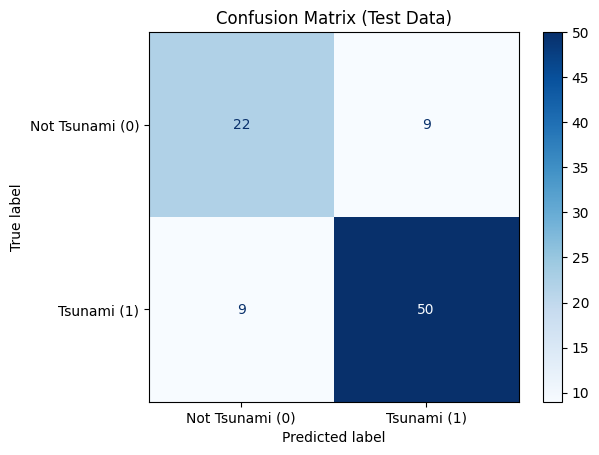


✅ Model Training & Evaluation Completed Successfully!


In [3]:
# =====================================================
# 🌊 Tsunami Risk Prediction using XGBoost Classifier
# =====================================================

# 1️⃣ Install missing packages (safe for Kaggle)
!pip install xgboost seaborn matplotlib scikit-learn --quiet

# 2️⃣ Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    classification_report,  
    accuracy_score, 
    balanced_accuracy_score, 
    roc_auc_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay
)

from xgboost import XGBClassifier

# =====================================================
# 3️⃣ Load Dataset
# =====================================================
df = pd.read_csv('earthquake_data_tsunami.csv')
print("✅ Data Loaded Successfully")
print(df.head(), "\n")

# =====================================================
# 4️⃣ Basic EDA (Exploratory Data Analysis)
# =====================================================
print(f"Number of rows: {len(df)}")
print("\nMissing Values:\n", df.isnull().sum())

# Tsunami occurrence count
sns.countplot(x='tsunami', data=df)
plt.title("Tsunami Occurrence Count")
plt.show()

# Magnitude category grouping
bins = [0,5,6,7,8,9,10]
labels = ['<5','5-6','6-7','7-8','8-9','9-10']
df['mag_category'] = pd.cut(df['magnitude'], bins=bins, labels=labels, right=False)

plt.figure(figsize=(12,7))
sns.countplot(x='mag_category', hue='tsunami', data=df)
plt.title("Tsunami Occurrence by Earthquake Magnitude Category")
plt.show()

# Depth vs Magnitude
sns.scatterplot(x='magnitude', y='depth', data=df, hue='tsunami')
plt.title("Tsunami Occurrence vs Earthquake Magnitude and Depth")
plt.show()

# Correlation Matrix
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# =====================================================
# 5️⃣ Bias Detection (Pre-2012 data issue)
# =====================================================
df_after_2012 = df[df['Year'] >= 2012].copy()
df_before_2012 = df[df['Year'] < 2012].copy()

plt.figure(figsize=(8,6))
sns.countplot(x='tsunami', data=df_after_2012)
plt.title("Tsunami Occurrence After 2012")
plt.show()

plt.figure(figsize=(8,6))
sns.countplot(x='tsunami', data=df_before_2012)
plt.title("Tsunami Occurrence Before 2012")
plt.show()

print("⚠️ Bias Found: Before 2012 → only 'tsunami=0' events.")
print("✅ Fix: Use data from 2012 onwards only.\n")

# =====================================================
# 6️⃣ Feature Engineering
# =====================================================
df_cleaned = df[df['Year'] >= 2012].copy()
df_cleaned = df_cleaned.drop(columns=['Year','Month','mag_category'])

# Features and Target
X = df_cleaned.drop(columns=['tsunami'], axis=1)
y = df_cleaned['tsunami']

# Split Data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("✅ Data Prepared: Train/Test Split Done\n")

# =====================================================
# 7️⃣ Model Training — XGBoost with GridSearchCV
# =====================================================
xgb_model = XGBClassifier(
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

param_grid_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
}

grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=1
)

print("🚀 Training XGBoost model with GridSearchCV...")
grid_search_xgb.fit(X_train, y_train)

best_model = grid_search_xgb.best_estimator_

# =====================================================
# 8️⃣ Model Evaluation
# =====================================================
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n" + "="*40)
print("🌟 MODEL: XGBClassifier (Optimized)")
print(f"Best Parameters: {grid_search_xgb.best_params_}")
print("="*40 + "\n")

print(f"1️⃣ Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"2️⃣ Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred):.4f}")
print(f"3️⃣ ROC AUC Score: {roc_auc_score(y_test, y_pred_proba):.4f}\n")

print("4️⃣ Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Not Tsunami (0)', 'Tsunami (1)']))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\n5️⃣ Confusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Tsunami (0)', 'Tsunami (1)'])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix (Test Data)")
plt.show()


